## NAMA : Muhammad Reza Giovanni
## Subsmission 2 - NLP

## IMPORT DATASET

In [1]:
import tensorflow as tf
import pandas as pd

In [2]:
url = 'https://raw.githubusercontent.com/rezagiovanni/project-nlp/master/bbc-text.csv'
df = pd.read_csv(url)
print(df)

           category                                               text
0              tech  tv future in the hands of viewers with home th...
1          business  worldcom boss  left books alone  former worldc...
2             sport  tigers wary of farrell  gamble  leicester say ...
3             sport  yeading face newcastle in fa cup premiership s...
4     entertainment  ocean s twelve raids box office ocean s twelve...
...             ...                                                ...
2220       business  cars pull down us retail figures us retail sal...
2221       politics  kilroy unveils immigration policy ex-chatshow ...
2222  entertainment  rem announce new glasgow concert us band rem h...
2223       politics  how political squabbles snowball it s become c...
2224          sport  souness delight at euro progress boss graeme s...

[2225 rows x 2 columns]


In [3]:
df.isnull().sum()

category    0
text        0
dtype: int64

In [4]:
df['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

## IMPORT STOPWORD, STEMMER AND DEFINE PUNCTS

In [5]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [7]:
nltk.download('wordnet')
nltk.download('stopwords')

signs = list(punctuation) # special characters 
stop_word = list(stopwords.words('english')) # stop words like `a,an,the,or,at` etc
wordnet_lemmatizer = WordNetLemmatizer() # make the word cooking,cooks,cooked -> cook (in ideal case)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## DEFINE FUNCTION FOR TEXT-PREPROCESSING

In [8]:
def clean_articles(df):

    #REPLACING    
    df['text'] = df['text'].str.replace("\r", " ")
    df['text'] = df['text'].str.replace("\n", " ")
    df['text'] = df['text'].str.replace("    ", " ")
    df['text'] = df['text'].str.replace('"', '')
    df['text'] = df['text'].str.lower()  
    for sign in signs:
        df['text'] = df['text'].str.replace(sign, '')
    df['text'] = df['text'].str.replace("'s", "")

    #LEMMATIZER
    nrows = len(df)
    lemmatized_text_list = []
    for row in range(nrows):
        lemmatized_list = [] 
        text = df.loc[row]['text'] 
        text_words = text.split(" ")
        for word in text_words:  
            lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        lemmatized_text = " ".join(lemmatized_list)  
        lemmatized_text_list.append(lemmatized_text) 
    df['text'] = lemmatized_text_list
    
    #REMOVING STOPWORDS
    for stop_woord in stop_word:
        re_sw = r"\b" + stop_woord + r"\b"
        df['text'] = df['text'].str.replace(re_sw, '')

## CLEANING TEXTS

In [9]:
clean_articles(df)

In [10]:
print(df)

           category                                               text
0              tech  tv future   hand  viewers  home theatre system...
1          business  worldcom boss  leave book alone  former worldc...
2             sport  tigers wary  farrell  gamble  leicester say   ...
3             sport  yeading face newcastle  fa cup premiership sid...
4     entertainment  ocean  twelve raid box office ocean  twelve   ...
...             ...                                                ...
2220       business  cars pull  us retail figure us retail sales fe...
2221       politics  kilroy unveil immigration policy exchatshow ho...
2222  entertainment  rem announce new glasgow concert us band rem  ...
2223       politics   political squabble snowball   become commonpl...
2224          sport  souness delight  euro progress boss graeme sou...

[2225 rows x 2 columns]


## SPLITTING CATEGORIES

In [11]:
kategori = pd.get_dummies(df.category)
df_baru = pd.concat([df, kategori], axis=1)
df_baru = df_baru.drop(columns='category')
df_baru

,text,business,entertainment,politics,sport,tech
0,tv future hand viewers home theatre system...,0,0,0,0,1
1,worldcom boss leave book alone former worldc...,1,0,0,0,0
2,tigers wary farrell gamble leicester say ...,0,0,0,1,0
3,yeading face newcastle fa cup premiership sid...,0,0,0,1,0
4,ocean twelve raid box office ocean twelve ...,0,1,0,0,0
...,...,...,...,...,...,...
2220,cars pull us retail figure us retail sales fe...,1,0,0,0,0
2221,kilroy unveil immigration policy exchatshow ho...,0,0,1,0,0
2222,rem announce new glasgow concert us band rem ...,0,1,0,0,0
2223,political squabble snowball become commonpl...,0,0,1,0,0


In [12]:
x = df_baru['text']
y = df_baru[['business','entertainment','politics','sport','tech']]

## SPLIT DATASET INTO TRAIN AND TEST

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 0)

## TOKENIZING

In [15]:
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
tokenize = text.Tokenizer(num_words = 1000)
tokenize.fit_on_texts(x_train)
 
x_train = tokenize.texts_to_sequences(x_train)
x_test = tokenize.texts_to_sequences(x_test)

x_train=pad_sequences(x_train, maxlen = 300)
x_test=pad_sequences(x_test , maxlen= 300)

## THE MODEL

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Activation, Dropout, Bidirectional, Embedding, LSTM, GlobalMaxPool1D

In [18]:
model = Sequential()
model.add(Embedding(input_dim = 1000, output_dim = 150, input_length = 300))
model.add(LSTM(64, recurrent_dropout = 0.5, return_sequences = False))
model.add(Dense(48, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation = 'softmax'))

## THE CALLBACKS

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, Callback

In [20]:
earlystop = EarlyStopping(monitor='val_loss', 
                          patience=2, 
                          )

In [21]:
# on_epoch_end CallBack
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('accuracy')>0.98) and (logs.get('val_loss')<=0.1)): 
      print(" ")
      print("(Akurasi > 98%) dan (val_loss <= 10%), maka training dihentikan")
      self.model.stop_training = True

oee_callback = myCallback()

In [22]:
callback = [oee_callback, earlystop]

## COMPILE

In [23]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 150)          150000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                55040     
_________________________________________________________________
dense (Dense)                (None, 48)                3120      
_________________________________________________________________
dropout (Dropout)            (None, 48)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 245       
Total params: 208,405
Trainable params: 208,405
Non-trainable params: 0
_________________________________________________________________


## FIT

In [24]:
batch_size = 64
epochs = 10    
hist = model.fit(x_train, 
                 y_train, 
                 batch_size = batch_size, 
                 epochs = epochs,
                 validation_data = (x_test,y_test),
                 verbose = 1,
                 callbacks = callback,
                 validation_split=0.2
                 )

Epoch 1/10
23/23 [==============================] - 12s 520ms/step - loss: 1.5835 - accuracy: 0.3406 - val_loss: 1.5016 - val_accuracy: 0.3876
Epoch 2/10
23/23 [==============================] - 12s 506ms/step - loss: 1.2109 - accuracy: 0.4838 - val_loss: 1.0434 - val_accuracy: 0.5590
Epoch 3/10
23/23 [==============================] - 12s 507ms/step - loss: 0.8304 - accuracy: 0.6650 - val_loss: 0.7112 - val_accuracy: 0.7865
Epoch 4/10
23/23 [==============================] - 12s 515ms/step - loss: 0.4622 - accuracy: 0.8532 - val_loss: 0.5254 - val_accuracy: 0.8652
Epoch 5/10
23/23 [==============================] - 12s 521ms/step - loss: 0.3043 - accuracy: 0.8989 - val_loss: 0.5494 - val_accuracy: 0.8455
Epoch 6/10
23/23 [==============================] - 12s 515ms/step - loss: 0.1976 - accuracy: 0.9431 - val_loss: 0.4432 - val_accuracy: 0.8820
Epoch 7/10
23/23 [==============================] - 12s 516ms/step - loss: 0.1086 - accuracy: 0.9789 - val_loss: 0.4204 - val_accuracy: 0.9157

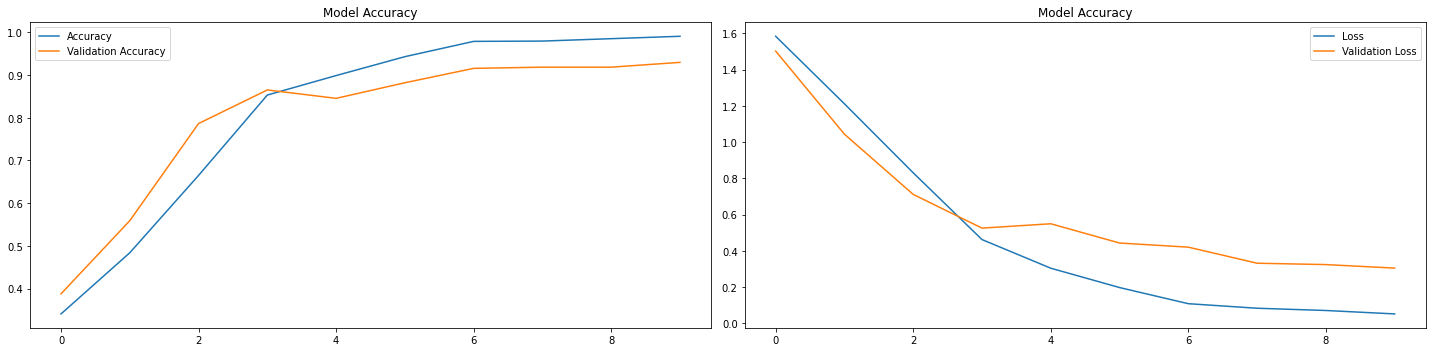

In [25]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(hist.history['accuracy'])
ax1.plot(hist.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.legend(["Accuracy", "Validation Accuracy"])

ax2.plot(hist.history['loss'])
ax2.plot(hist.history['val_loss'])
ax2.set_title('Model Accuracy')
ax2.legend(["Loss","Validation Loss"])

plt.tight_layout()